In [ ]:
import kagglehub
import shutil
import os

# Step 1: Download the dataset (default path used by kagglehub)
original_path = kagglehub.dataset_download("shayanfazeli/heartbeat")

# Step 2: Define your desired target path
target_path = "/content/heart"  # <- Change this

# Step 3: Move the dataset to the new location
if not os.path.exists(target_path):
    shutil.move(original_path, target_path)
    print("Dataset moved to:", target_path)
else:
    print("Target path already exists:", target_path)

Target path already exists: /content/heart


Epoch 1/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.8338 - loss: 0.5629 - val_accuracy: 0.6685 - val_loss: 0.8036
Epoch 2/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.9025 - loss: 0.3451 - val_accuracy: 0.8781 - val_loss: 0.3489
Epoch 3/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9449 - loss: 0.1990 - val_accuracy: 0.9486 - val_loss: 0.1688
Epoch 4/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9549 - loss: 0.1619 - val_accuracy: 0.9609 - val_loss: 0.1427
Epoch 5/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9638 - loss: 0.1313 - val_accuracy: 0.9617 - val_loss: 0.1387
Epoch 6/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9683 - loss: 0.1134 - val_accuracy: 0.9693 - val_loss: 0.1140
Epoch 7/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.9710 - loss: 0.1025 - val_accuracy: 0.9455 - val_loss: 0.2336
Epoch 8/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9601 - loss: 0.1437 - 

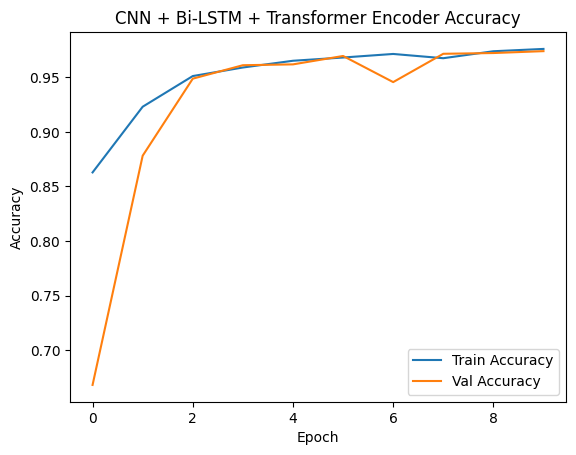

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ✅ Load Dataset
train_df = pd.read_csv("/content/heart/mitbih_train.csv", header=None)
test_df = pd.read_csv("/content/heart/mitbih_test.csv", header=None)

X_train = train_df.iloc[:, :-1].values.reshape(-1, 187, 1)
y_train = train_df.iloc[:, -1].values.astype(int)

X_test = test_df.iloc[:, :-1].values.reshape(-1, 187, 1)
y_test = test_df.iloc[:, -1].values.astype(int)

# ✅ Transformer Encoder Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ✅ Build Model with Transformer
def build_model():
    inputs = tf.keras.Input(shape=(187, 1))

    x = tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

    # Transformer encoder
    x = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=256)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# ✅ Compile Model
model = build_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_test, y_test))

# ✅ Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ✅ Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("CNN + Bi-LSTM + Transformer Encoder Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


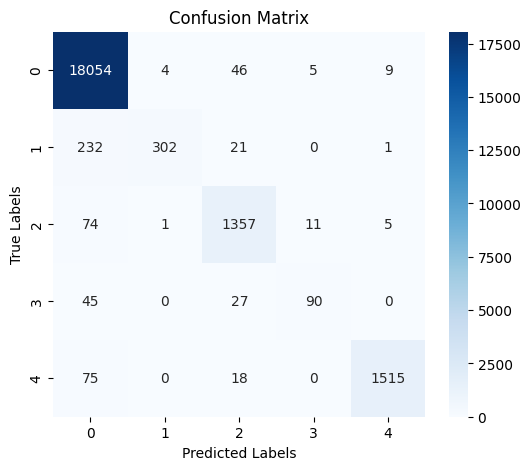

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18118
           1       0.98      0.54      0.70       556
           2       0.92      0.94      0.93      1448
           3       0.85      0.56      0.67       162
           4       0.99      0.94      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.94      0.79      0.85     21892
weighted avg       0.97      0.97      0.97     21892



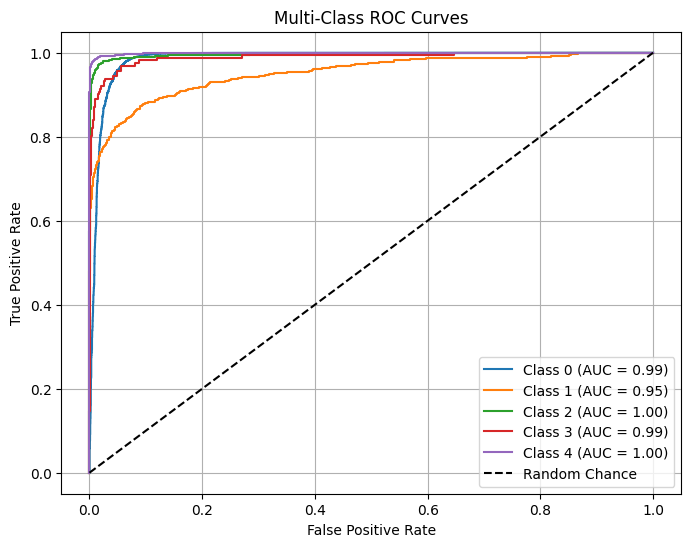

Macro AUC: 0.9841
Weighted AUC: 0.9869


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Predict probabilities
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ✅ Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# ✅ ROC Curve (Multi-class)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # One-hot encoding
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Plot all ROC Curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# ✅ Macro & Weighted AUC
macro_auc = roc_auc_score(y_test_bin, y_probs, average='macro', multi_class='ovr')
weighted_auc = roc_auc_score(y_test_bin, y_probs, average='weighted', multi_class='ovr')
print(f"Macro AUC: {macro_auc:.4f}")
print(f"Weighted AUC: {weighted_auc:.4f}")


In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 22.7 MB/s eta 0:00:00


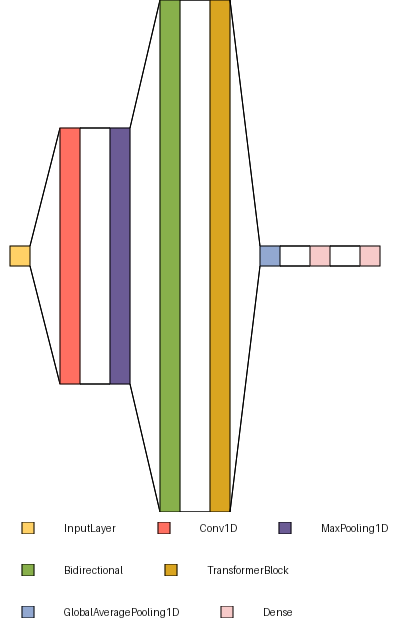

In [ ]:
import tensorflow as tf
import visualkeras
from tensorflow.keras import layers
from collections import defaultdict
from PIL import ImageFont

# --- Custom Transformer Block ---
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# --- Build Model ---
def build_model():
    inputs = tf.keras.Input(shape=(187, 1), name="Input")
    x = layers.Conv1D(64, kernel_size=5, activation='relu', name="Conv1D")(inputs)
    x = layers.MaxPooling1D(pool_size=2, name="MaxPooling")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True), name="BiLSTM")(x)
    x = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=256)(x)
    x = layers.GlobalAveragePooling1D(name="GlobalAvgPool")(x)
    x = layers.Dense(64, activation='relu', name="Dense")(x)
    outputs = layers.Dense(5, activation='softmax', name="Output")(x)
    return tf.keras.Model(inputs, outputs, name="Elegant_Model")

model = build_model()

# --- Proper Color Map ---
color_map = {
    tf.keras.layers.Conv1D: {"fill": "#FF6F61", "outline": "black"},
    tf.keras.layers.MaxPooling1D: {"fill": "#6B5B95", "outline": "black"},
    tf.keras.layers.Bidirectional: {"fill": "#88B04B", "outline": "black"},
    tf.keras.layers.LSTM: {"fill": "#88B04B", "outline": "black"},
    tf.keras.layers.Dense: {"fill": "#F7CAC9", "outline": "black"},
    tf.keras.layers.GlobalAveragePooling1D: {"fill": "#92A8D1", "outline": "black"},
    tf.keras.layers.MultiHeadAttention: {"fill": "#DAA520", "outline": "black"},
    tf.keras.layers.LayerNormalization: {"fill": "#DAA520", "outline": "black"},
    TransformerBlock: {"fill": "#DAA520", "outline": "black"},
}

# --- Optional: Load custom font ---
try:
    font = ImageFont.truetype("arial.ttf", 12)
except:
    font = None

# --- Generate the architecture diagram ---
visualkeras.layered_view(
    model,
    to_file='elegant_model_architecture.png',
    legend=True,
    color_map=color_map,
    spacing=30,
    draw_volume=False,
    font=font
)
